# RAI Exercise 1: Algorithmic Fairness ⚖️

# Important information
This exercise is part of the RAI course (02517 - **Responsible AI: Algorithmic Fairness and Explainability**) at the Technical University of Denmark (DTU). You can find more details about the course [here](https://kurser.dtu.dk/course/02517). This specific version is for the Fall 2024 semester.

If you have any questions related to this notebook, feel free to reach out to Nina Weng at *ninwe@dtu.dk*.

**Credits**:  
We thank:
* NIH dataset team for collecting such dataset [link to the paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf);
* Authors from [this paper](https://link.springer.com/chapter/10.1007/978-3-031-45249-9_14) for providing the splits;
* [Memes generator webpage imgflip](https://imgflip.com/) for all the excellent Memes template.


# PART 1: Fairness assessment and Bias mitigation using Fairlearn

The goal of this exercise is to learn how to use [Fairlearn](https://fairlearn.org/) to approach basic fairness assessments and apply post-processing bias mitigation methods. 

Fairlearn is an open-source Python package originally developed by Microsoft Research. Since 2021, it has become completely community-driven. For more information about Fairlearn, you can visit [this page]((https://fairlearn.org/v0.10/about/index.html)). 

Although Fairlearn is likely the most well-developed package targeting fairness issues, it has its limitations. The most notable limitation, that might need to be mentioned at very beginning for this exercise, is that Fairlearn is primarily designed for tabular data ([this page](https://fairlearn.org/main/faq.html) under question: *Does Fairlearn work for image and text data?*). Therefore, when working with other types of data, such as image data, unexpected issues may arise. Fortunate enough, there are workarounds for most of these issues, which will be discussed later in this exercise.

While Fairlearn is a good resource and offers an easy approach for learning fairness concepts and handling lighter tasks, it may not be the best solution for researchers working extensively in this area. Keep that in mind :-)

## 🧠 Objective of this Exercise (PART 1)
By the end of this exercise, you should be able to:

* Assess fairness using Fairlearn with provided predictions/probabilities and target labels. This includes calculating metrics, generating ROC curves, and interpreting their meaning.
* Apply post-processing bias mitigation techniques using Fairlearn, and clearly understand and explain the outcomes.

![](./support4notebook/getstarted.jpg)

## 1. Dataset: Chest X-ray and lung/heart related disease


In this exercise, we will use a chest X-ray dataset and a basic deep learning model as the setup. It requires the following:

* Download the dataset/metadata/pretrained ResNet model. Note that in this exercise, we only use part of the data, and details are listed below. The full dataset can be found [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). (For students in the class, you can find a download link on DTU Learn. For those not in the class, you can find the pre-processing scripts in [this repository](https://github.com/nina-weng/detecting_causes_of_gender_bias_chest_xrays).)
* After downloading the materials, put the `NIH_train_val_test_rs0_f50.csv` under `./datafiles/`; and `nih_pneumothorax.pth` under `./pretrained_model/`.
* Prepare your virtual environment: 
`conda env create -f env.yml`


### Chest xray samples
We use [NIH chest xray dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) in this exercise. Let’s take a closer look at the dataset. </br>

This dataset contains 108,948 images from 32,717 patients, each labeled with one of 14 types of lung or heart-related diseases/symptoms. For detailed information on each disease, you can find explanations [here](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/220660789610).

For simplicity, we will use only one sample per patient and preprocess the images to a size of 224x224. Both the dataset and the metadata (in CSV format) are available. The dataset split is also specified in the metadata under the column 'split'.

Note: The split was designed for a different task, which required a larger test set than usual. As a result (as you’ll notice), the test set is relatively large (around 8k for training, 2k for validation, and 8k for testing). If you find that the mitigation or prediction process takes too long, feel free to downsample the test set. Just ensure you validate that the proportions of samples across different sensitive groups and disease labels remain roughly consistent with the original test set.  

In [73]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import torch

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate


#
from train.model import ResNet
from train.prediction import validate
from analysis.plot import plot_roc_simple
from analysis.tools import from_loader_to_tensor

In [74]:
#TODO: change this to your data directory
datadir = 'datafiles'

Let us take a look of some samples, with filter query. 

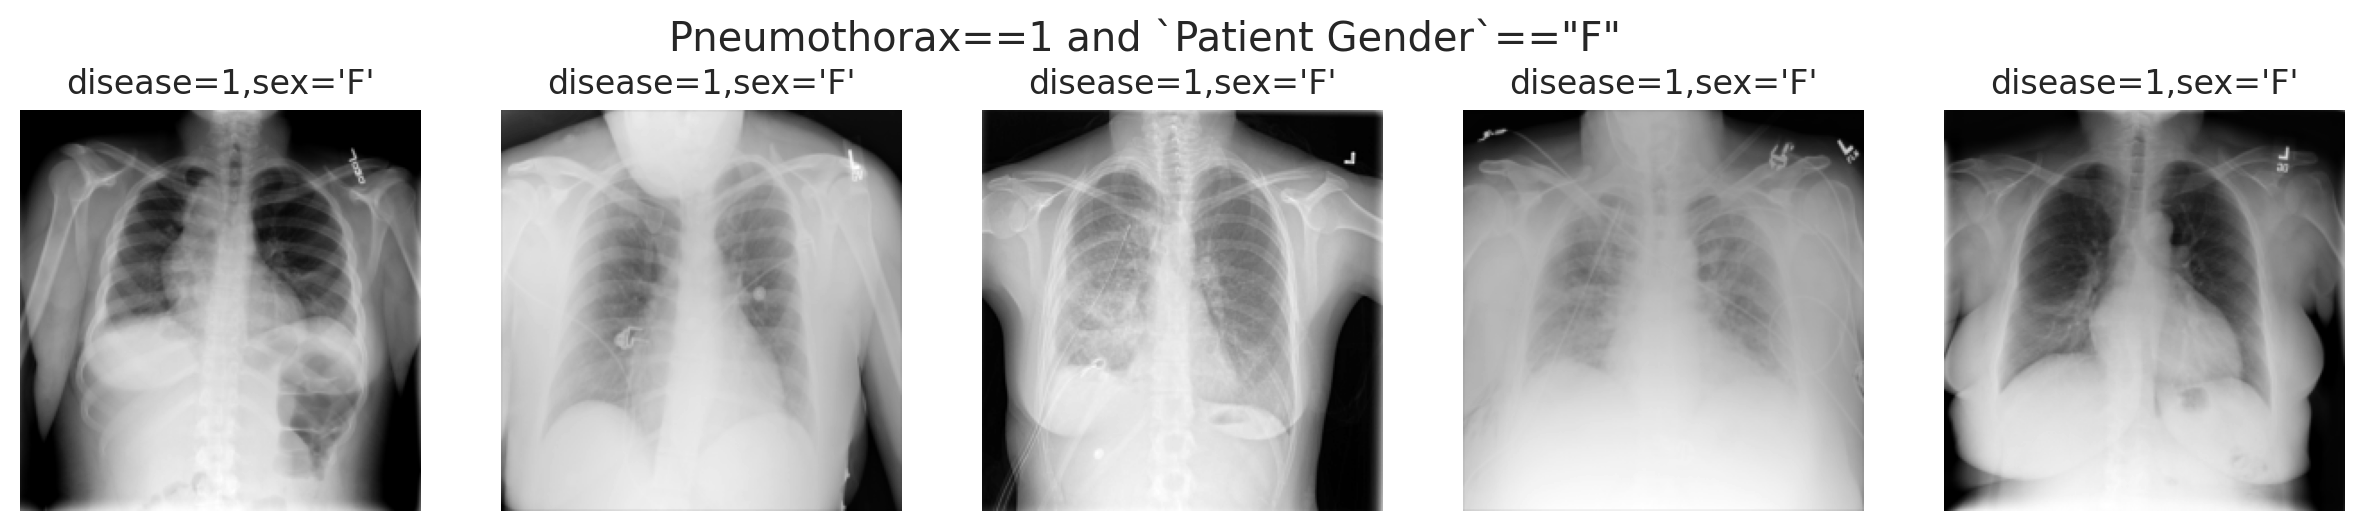

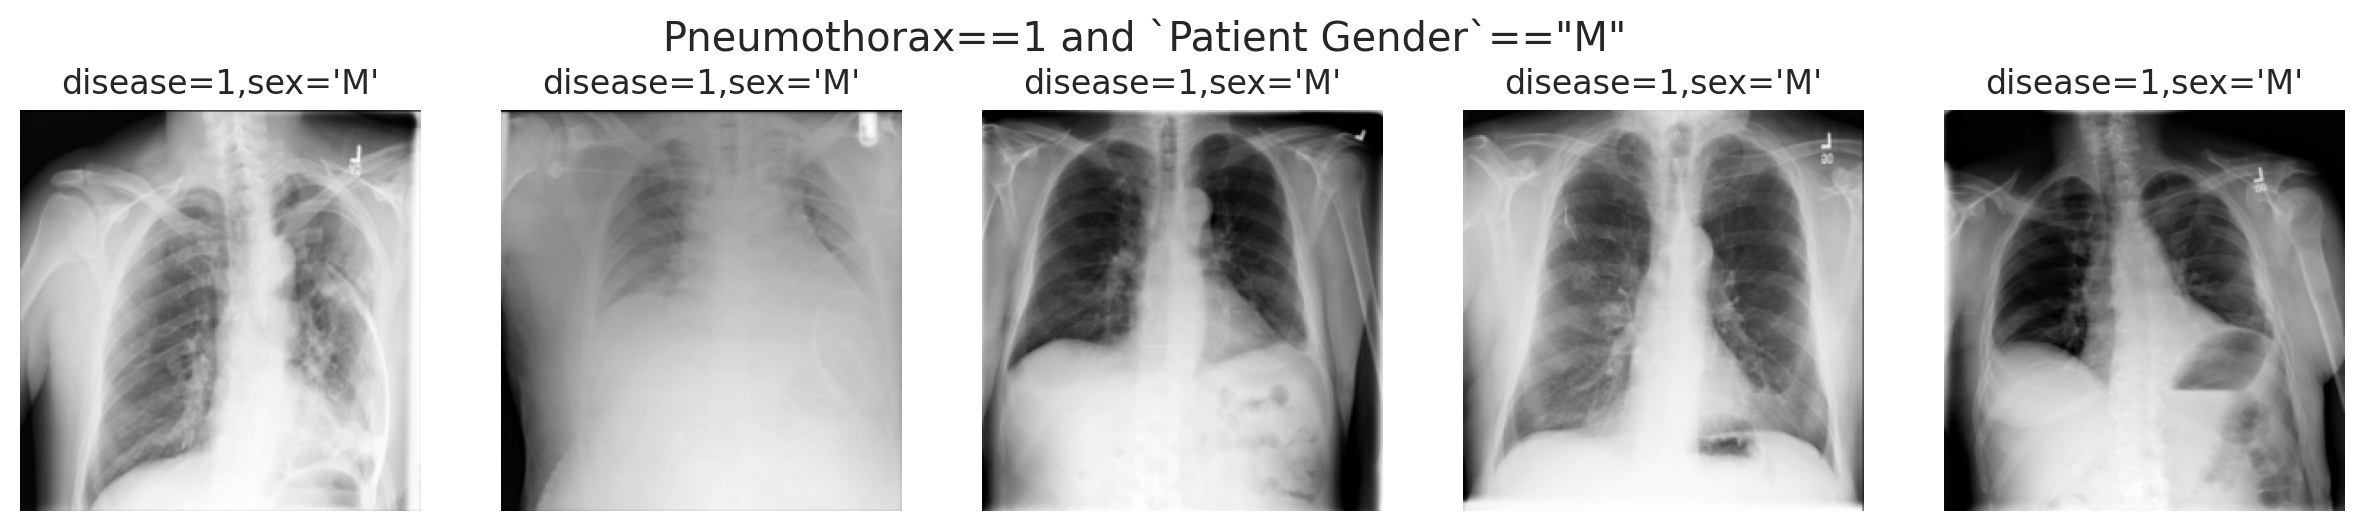

In [75]:
dataset_pth = datadir + '/NIH_part/'
metadata_csv ='./datafiles/NIH_train_val_test_rs0_f50.csv'
metadata = pd.read_csv(metadata_csv)

# display(metadata.head(5))

# randomly choose some samples from PAD-UFES-20
def show_random_images(datadir,metadata,seed=None,filter_str=None,num_sample=5):
    fig = plt.figure(figsize=(num_sample*3, 3),dpi=200)
    files = os.listdir(datadir)
    if filter_str:
        metadata = metadata.query(filter_str)
        # display(metadata.head(5))
    if seed is not None:
        random_sample = metadata.sample(n=num_sample, random_state=seed)
    else: random_sample = metadata.sample(n=num_sample)
    
    for i in range(len(random_sample)):
        row = random_sample.iloc[i]
        disease = row['Pneumothorax']
        sex = row['Patient Gender']

        img = mpimg.imread(datadir + row['Image Index'])
        ax = fig.add_subplot(1, len(random_sample), i + 1)
        # add diagnosis as subtitle
        ax.set_title(f'{disease=},{sex=}')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle(f'{filter_str}')
    plt.show()

show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="F"',num_sample=5)
show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="M"',num_sample=5)

### Basic statistics

We can also take a look at the distribution of some sensitive attributes:

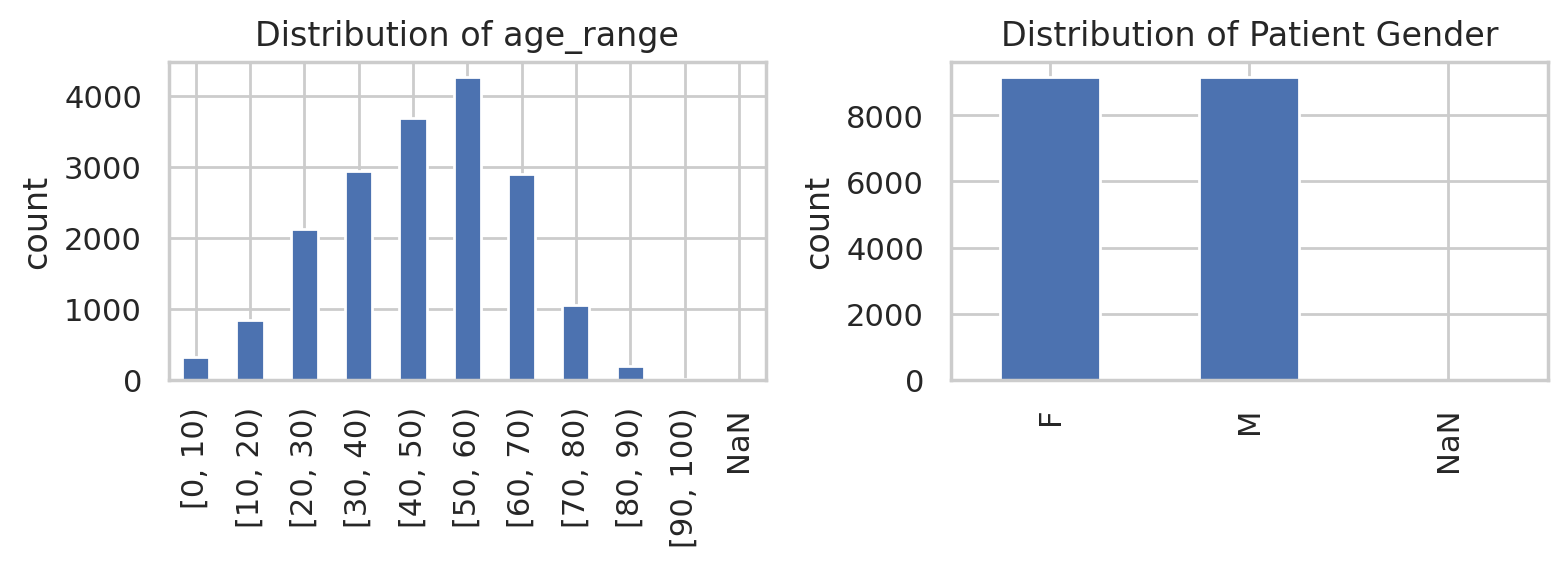

In [76]:
def plot_distribution_by_value(metadata, column_name):
    if isinstance(column_name, str):
        nan_count = metadata[column_name].isna().sum()
        nan_series = pd.Series([nan_count], index=['NaN'])
        counts_ = metadata[column_name].value_counts().sort_index()
        counts_with_nan = pd.concat([counts_, nan_series])

        counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(column_name))
        plt.ylabel('count')
    elif isinstance(column_name, list):
        fig, axes = plt.subplots( 1, len(column_name), figsize=( len(column_name)*4,3),dpi=200)
        for i,col in enumerate(column_name):
            nan_count = metadata[col].isna().sum()
            nan_series = pd.Series([nan_count], index=['NaN'])
            counts_ = metadata[col].value_counts().sort_index()
            counts_with_nan = pd.concat([counts_, nan_series])

            counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(col),ax=axes[i])
            axes[i].set_ylabel('count')
    plt.tight_layout()
    plt.show()

metadata['age_range'] = pd.cut(metadata['Patient Age'], bins=[0,10,20,30,40,50,60,70,80,90,100], right=False)
plot_distribution_by_value(metadata, ['age_range','Patient Gender'])

You may have noticed that, for this specific split, we maintain an equal number of male and female samples. This balance is consistent across all three splits: training, validation, and testing.

### 📃 Further Reading:
If you're interested, here are some studies that explore potential biases and confounders in chest xray datasets:
* [Lauren Oakden-Rayner: Exploring the ChestXray14 dataset: problems](https://laurenoakdenrayner.com/2017/12/18/the-chestxray14-dataset-problems/)
> Three problems talked about 1-how accurate the labels are. 2-what the labels actually mean, medically. 3-how useful the labels are for image analysis.
* [Amelia Jiménez-Sánchez et al.: Detecting Shortcuts in Medical Images -- A Case Study in Chest X-rays](https://arxiv.org/abs/2211.04279)
* [Judy Wawira Gichoya et al.: AI recognition of patient race in medical imaging: a modelling study](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00063-2/fulltext)

## 2. Fairness assessment
**Recap of Key Concepts**:

In th class, we have learned:
* The three key criteria for fairness assessment. What are they?
> 1.Independence 2.Separation(Equalized Odds) 3.Sufficiency
* Evaluation metrics corresponding to each criterion.
>**1. Independence**
>
>**metric**: selection_rate
>
>**definition**: A classifier satisfies independence if the probability of a positive prediction is the same for different groups (sensitive features). $$ P(\hat{Y} = 1 \mid A = a) = P(\hat{Y} = 1 \mid A = b) $$
>
>**2. Separation**
>
>**metric**: TPR(recall_score), FPR(get through recall_score and confusion matrix)
>
>**definition**: A classifier satisfies equalized odds if the true positive rate (TPR) and false positive rate (FPR) are the same across different groups. This ensures that the model's accuracy is fair in both cases where the actual outcome is positive or negative.
>
>**3. Sufficiency**
>
>**metric**: precision_score
>
>**definition**: A classifier satisfies sufficiency if the positive predictive value (PPV or precision) is the same across groups. This ensures that, given a positive prediction, the outcome is fair across groups.


* ROC curves.
>
For this exercise, we’ve provided a pre-trained ResNet classifier for Part 1, where the disease label is `Pneumothorax` and the sensitive attribute is `sex` (in metadata, you can get the binarized sex label from column `sex label`, where 0 represents female and 1 represents male). However, feel free to train your own model if you'd like.



### Load pretrained model

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(' device:', device)

 device: cuda


In [78]:
# load the pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(' device:', device)

ds_name = 'NIH'

# load the model
lr=1e-6
pretrained = True
model_scale = '18'
num_epochs =20
img_size = (1, 224, 224)

classifier = ResNet(num_classes=1, lr=lr, pretrained=pretrained, model_scale=model_scale, in_channel=img_size[0])
# classifier.load_state_dict(torch.load('./pretrained_model/nih_pneumothorax.pth'))

# use cpu
classifier.load_state_dict(torch.load('./pretrained_model/nih_pneumothorax.pth', map_location=torch.device('cpu')))

classifier.to(device)

classifier.eval()


 device: cuda


/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Load test and validation data

In [79]:
save_model_at = './pretrained_models/'

img_size = (1,224,224)
batch_size = 16

csv_pth = './datafiles/NIH_train_val_test_rs0_f50.csv' if ds_name == 'NIH' else None

disease_label = 'Pneumothorax' 
sensitive_label = 'sex'
augmentation = False

from train.train_chestxray import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(dataset_pth, 
                                                               ds_name,
                                                               csv_pth, 
                                                               image_size=img_size, 
                                                               device=device,
                                                               disease_label = disease_label,
                                                               sensitive_label = sensitive_label,
                                                               augmentation=augmentation)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we dont need it here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loading Data: 100%|████████████████████████████████████████████| 8459/8459 [00:00<00:00, 22657.45it/s]


### Predict the results for test set

In [80]:
test_lab, test_pred, test_prob, test_a= validate(classifier, test_loader, device=device)

100%|███████████████████████████████████████████████████████████████| 529/529 [00:25<00:00, 20.82it/s]

val_loss=1.2348 val_acc=0.8094 val_auroc=0.7726


### Assess fairness using Fairlearn
#### A simple example first

Fairlearn provides the `fairlearn.metrics.MetricFrame` class to help with this quantification. 

Given: 
<pre>
y_true = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
sf_data = ['b', 'b', 'a', 'b', 'b', 'c', 'c', 'c', 'a',
           'a', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'c']
</pre>
           


![](./support4notebook/exercise_time.gif)

Try: 
* measure: recall, selection rate and false positive rate for *each group*;
* plot the above result out; ([Hint](https://fairlearn.org/main/user_guide/assessment/plotting.html))
* measure the difference in eqaulized odd between different groups;


Hint: The documentation page of [MetricFrame](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.MetricFrame.html#fairlearn.metrics.MetricFrame)

In [81]:
# y_true = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
# y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
# sf_data = ['b', 'b', 'a', 'b', 'b', 'c', 'c', 'c', 'a',
#            'a', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'c']
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'false_positive_rate': false_positive_rate,
           'true_positive_rate': true_positive_rate,
           'false_negative_rate': false_negative_rate,
           'true_negative_rate': true_negative_rate}
# mf1 = MetricFrame(metrics=metrics,y_true=y_true, y_pred=y_pred, sensitive_features=sf_data)
# mf1.by_group

### Now measure the fairness metrics for our data

![](./support4notebook/exercise.jpg)

In [82]:
mf_original = MetricFrame(metrics=metrics,
                 y_true=test_lab,
                 y_pred=test_pred,
                 sensitive_features=test_a)

print("Test set fairness metrics (before mitigation):")
mf_original.by_group

Test set fairness metrics (before mitigation):


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate
sensitive_feature_0,,,,,,
0.0,0.769213,0.244029,0.222028,0.619658,0.380342,0.777972
1.0,0.849645,0.155083,0.137463,0.556180,0.443820,0.862537


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

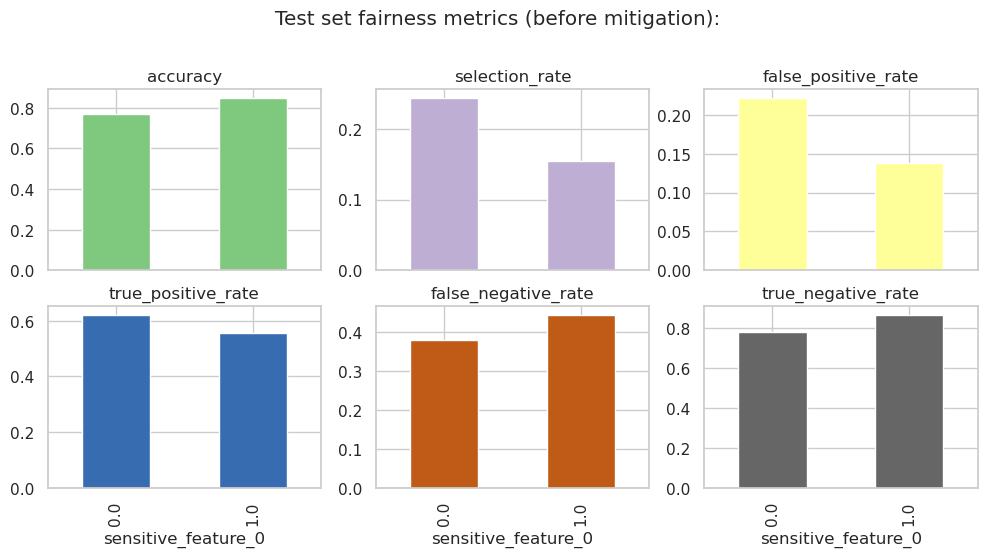

In [83]:
# Customize plots with colormap
mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (before mitigation):",
)

### Draw the ROC curve

Here we provide the funtion `plot_roc_simple` to draw the ROC curve for each groups.

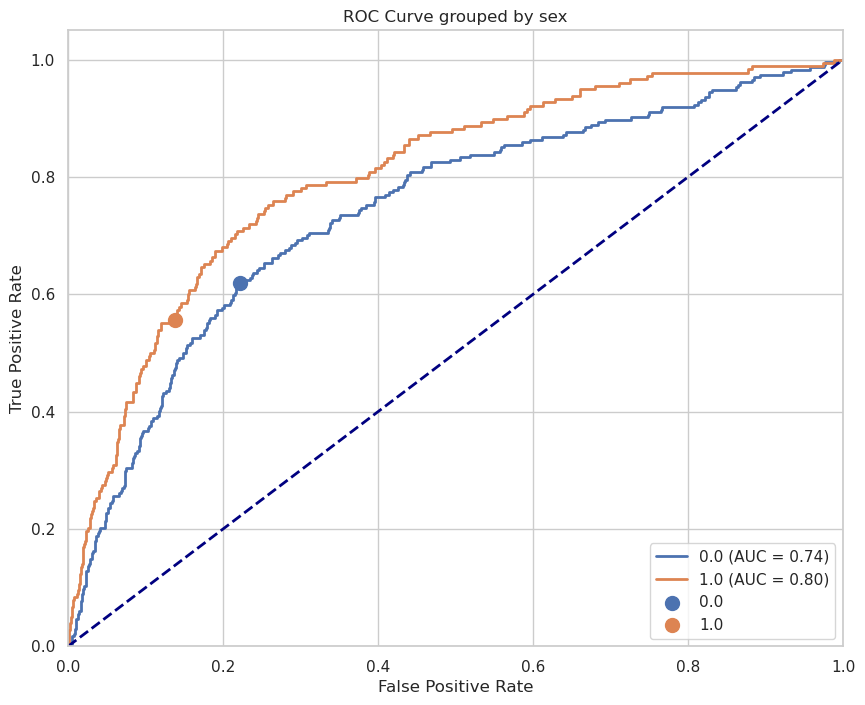

In [84]:
plot_roc_simple(test_lab, test_prob, test_a, test_pred,
        sensitive_attribute_name ='sex',
        )

### 💥 Exercise and discusssion:
* What do you see from the metrics and the ROC curve?
> Metrics:  group 0 and 1 have different metrics values. We need to make a trade-off according to what we want.
>
> ROC curve: For the same classifier, the performance of group 1 is better than that of group 2.

* Try to measure and desribe the fairness wrt the 3 creterias we learned from class
>Independence-> selection rate=$\frac{TP+FP}{TP+FP+TN+FN}$, it only refers to the probabilisty of being predicted to postive.
>
>Separation(Equalized odds)-> equal TPR=$\frac{TP}{TP+FN}$  and FPR
>
>Sufficiency-> PPV(positive predictive Value)=$\frac{TP}{TP+FP}$, NPV(negative predictive value)=$\frac{TN}{TN+FN}$


## 3. Bias mitigation using Fairlearn

### Recall from the class
* what kinds of mitigation methods have we learned?
> **1.** pre-processing(dataset-label)----Reweighting, Data Transformation, resampling(increase/decrease some specific group of people)
>
> **2.** Inprocessing  ---- add fairness restriction. Exponentiated Gradient Reduction, Grid Search
>
> **3.** Post-processing ---- ThresholdOptimizer( 根据不同群体的敏感属性，调整模型的决策阈值，使得不同群体在预测正类或负类时表现更为公平。调整模型输出的概率分布或决策结果，以平衡不同群体的预测结果。)
>
> **4.** Multiple Objective Optimization ---- Exponentiated Gradient Algorithm (在训练模型时，将公平性指标与性能指标（如准确率）一同优化，寻求两者之间的平衡)

In this exercise, we will try to use the one pf the post-preprocessing bias mitiagtion method Fairlearn provided: **Threshold Optimization**, to implement the bias mitigation steps. 

### The theory of Threshold Optimization


The idea could be simply visualized as below (figure from the [original paper](https://arxiv.org/pdf/1610.02413)):  
![](./support4notebook/threshold_op.png)

Where blue/green represent two sensitive groups, any points in the overlapping region meet the requirement of equalized odds:

$$
\gamma_0(\hat{Y}) = \gamma_1(\hat{Y}),
$$

where 

$$
\gamma_a (\hat{Y}) = \left(Pr(\hat{Y} = 1 | A = a, Y = 0), Pr(\hat{Y} = 1 | A = a, Y=1)\right).
$$

The goal of the threshold optimizer is to find the point in the overlapping region that optimizes the objective function, such as balanced accuracy.

To achieve this, **randomization** is introduced. The idea is starightforward: any point under the ROC curve can be estimated by weighting two points on the ROC curve (which could be achieved by simply thresholding); or in another word, a new decision threshold $T_a$ can be a randomized mixture of two decision thresholds $\underline{t}_a$ and $\overline{t}_a$.

(See the figure below, which is from [this paper](https://arxiv.org/abs/2202.08536)).

![Randomization Figure](./support4notebook/randomization.png)


📃 Further Reading:
* [Fairlearn *ThresholdOptimizier* page](https://fairlearn.org/v0.5.0/api_reference/fairlearn.postprocessing.html).
* The original paper (See section 3): [Equality of opportunity in supervised learning](https://arxiv.org/pdf/1610.02413).




### 🪄 Trick: A fake classifier class

Fairlearn has some limitations when implementing the `ThresholdOptimizer` method. To work around these issues, a fake classifier is provided to bypass minor problems. If you use the provided classifier, this fake class should work just as well.

However, if you're curious about what went wrong or want to use your own classifier, please read below:

* **Problem 1: `estimator` in `ThresholdOptimizer` only accepts 2D input (tabular data).** This doesn’t make sense for post-processing mitigation methods, as the only relevant aspect here is the prediction scores from the test set. The classifier itself and the input data are irrelevant when optimizing the threshold.
  
* **Problem 2: The `prefit` parameter checks whether the model has been fitted in a simplistic way, leading to errors.** You can read more about this fit check function [here](https://scikit-learn.org/stable/modules/generated/sklearn.utils.validation.check_is_fitted.html).
  
* **Problem 3: It requires the prediction function to return scores for both classes in binary classification.** This might be an issue if your classifier only provides the probability for class 1.

**How we solve this**: We create a fake classifier that accepts 2D input and reshapes it back to the original image size before feeding it into the prediction function. We trick the fit check by defining a fake variable and manually modify the output of the prediction function to include both classes if it only returns the probability for class 1.

Note: If you trained your own classifier, you will need to implement a custom fake classifier yourself.

In [85]:
from sklearn.base import BaseEstimator, ClassifierMixin

class FakeClassifierInput2D(BaseEstimator,ClassifierMixin):
    '''
    Fake classifier that takes 2D input, with pre-trained model that does not take 2D input data
    '''
    def __init__(self,model, img_size):
        self.model = model
        self.img_size = img_size
        self.input_from_2D_func = lambda x: torch.reshape(x,(-1,)+self.img_size)
        # self.input_from_2D_func = input_from_2D_func
        self.fit_ = True # fake the check_fit function inside the fairlearn library

    def fit(self, X, y):
        # Do not need to fit
        # self.is_fitted_ = True  # This ensures check_is_fitted works
        return

    def predict(self, X_2D, ):
        assert len(X_2D.shape) == 2
        X = self.input_from_2D_func(X_2D)
        return self.model.predict(X)
    
    def predict_proba(self, X_2D):
        X = self.input_from_2D_func(X_2D)
        return self.model.predict_proba(X)
    


### Optimize on validation set

In [86]:
X_test, y_test, a_test = from_loader_to_tensor(test_loader,device)
X_val, y_val, a_val = from_loader_to_tensor(val_loader,device)

X_test_2D = torch.reshape(X_test,(X_test.shape[0],-1))
X_val_2D = torch.reshape(X_val,(X_val.shape[0],-1))

100%|███████████████████████████████████████████████████████████████| 529/529 [00:17<00:00, 29.90it/s]


X.shape=torch.Size([8459, 1, 224, 224]), y.shape=torch.Size([8459]), a.shape=torch.Size([8459])


100%|█████████████████████████████████████████████████████████████████| 89/89 [00:03<00:00, 25.88it/s]


X.shape=torch.Size([1409, 1, 224, 224]), y.shape=torch.Size([1409]), a.shape=torch.Size([1409])


In [87]:
classifier_fake = FakeClassifierInput2D(model=classifier.to('cpu'), img_size = img_size)

Your code here:

In [88]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing import plot_threshold_optimizer
# Step 2: define ThresholdOptimizer
threshold_opt = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='equalized_odds', # TPR,FPR
    objective='balanced_accuracy_score',  
    predict_method='predict_proba',
)

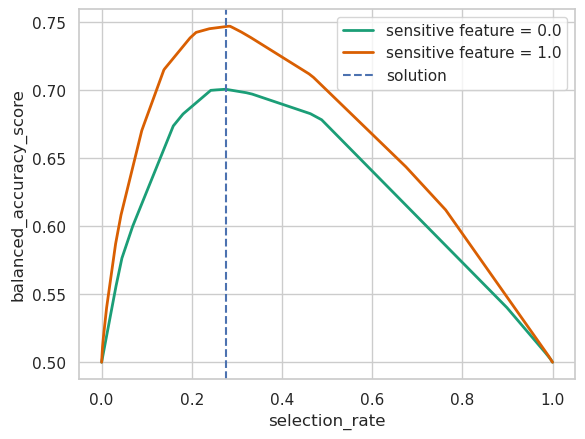

In [89]:
"""
This part we define a new Threshold Optimizer with Independence as constraint.
"""
# define Threshold Opt ---constraints with Independence
to_demograph = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='demographic_parity', # Independence
    objective='balanced_accuracy_score',  
    predict_method='predict_proba',
)

# fit ThresholdOptimizer
to_demograph.fit(X_test_2D, y_test, sensitive_features=a_test)

# plot_threshold_optimizer
plot_threshold_optimizer(to_demograph, ax=None, show_plot=True)

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

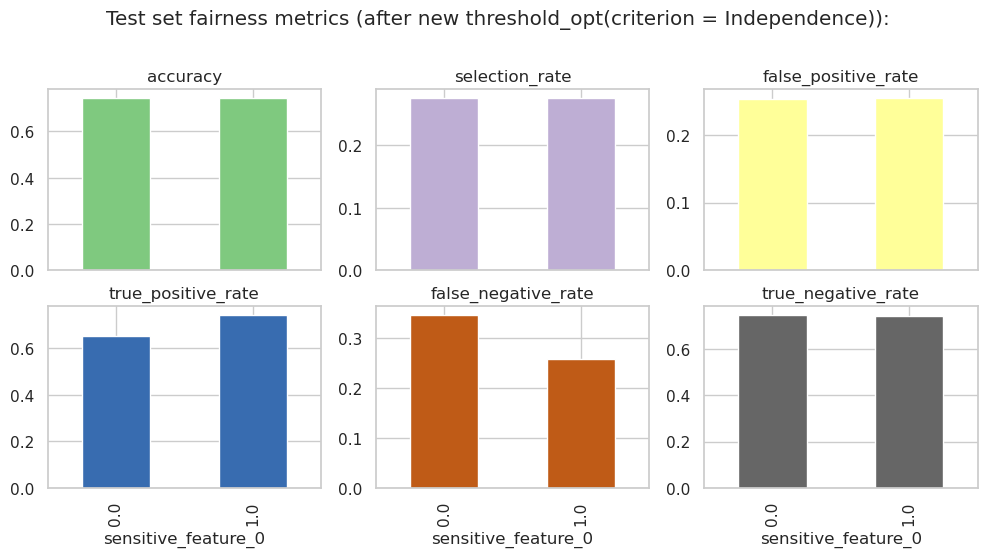

In [90]:
"""
This part we use the new Threshold Optimizer(constraint = 'demographic_parity' -> criterion = Independence) for the test set.
"""
y_pred_new_threshold_opt = to_demograph.predict(X_test_2D, sensitive_features=a_test)

mf_new_threshold_opt = MetricFrame(metrics=metrics,
                 y_true=test_lab,
                 y_pred=y_pred_new_threshold_opt,
                 sensitive_features=test_a)

mf_new_threshold_opt.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (after new threshold_opt(criterion = Independence)):",
)


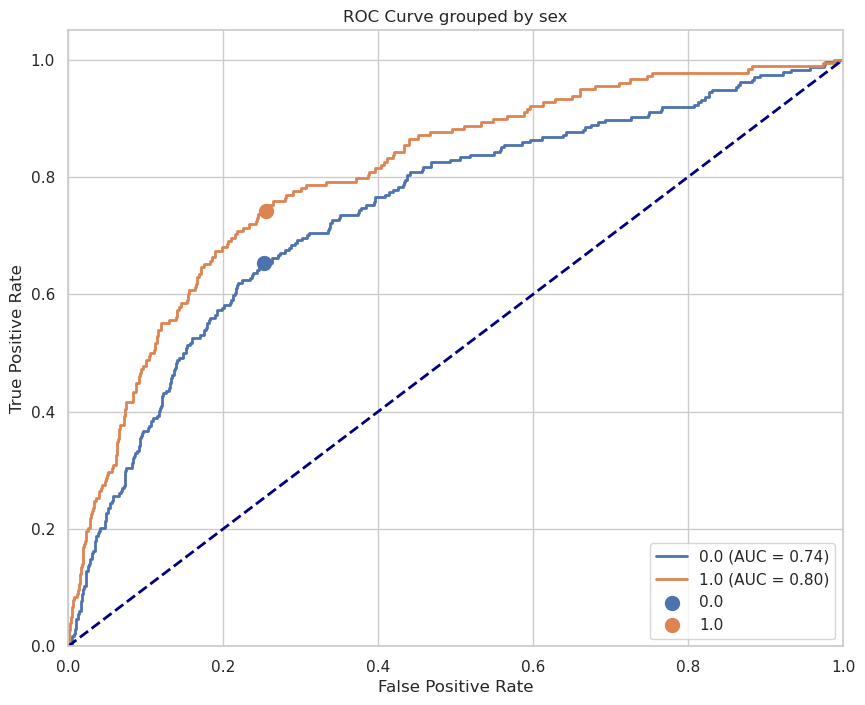

In [91]:
"""
This part we use the new Threshold Optimizer(constraint = 'demographic_parity' -> criterion = Independence) for the test set.
"""
plot_roc_simple(test_lab, test_prob, test_a, y_pred_new_threshold_opt,
        sensitive_attribute_name = 'sex',
        )

In [92]:
# Step 3: fit ThresholdOptimizer
threshold_opt.fit(X_test_2D, y_test, sensitive_features=a_test)
# threshold_opt.fit(X_val_2D, y_val, sensitive_features=a_val)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=FakeClassifierInput2D(img_size=(1, 224, 224),
                                                   model=ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, strid...
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=512, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
  (accu_func): BinaryAccuracy()
  (auroc_func): BinaryAUROC()
)),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba')

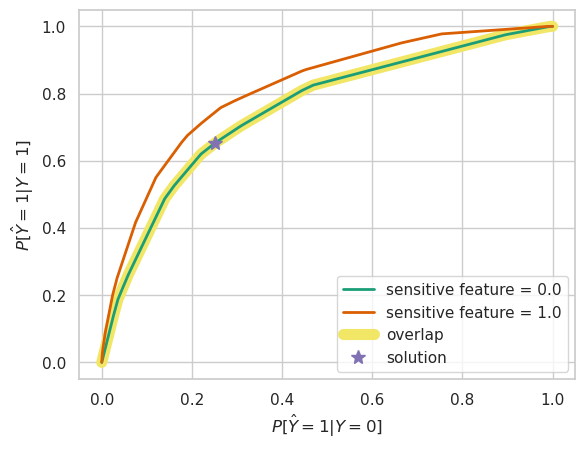

In [93]:
plot_threshold_optimizer(threshold_opt, ax=None, show_plot=True)

### Use the new threshold for the test set

Your code here:

In [94]:
y_pre_fair_test = threshold_opt.predict(X_test_2D, sensitive_features=a_test)

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


In [95]:
mf = MetricFrame(metrics=metrics,
                 y_true=test_lab,
                 y_pred=y_pre_fair_test,
                 sensitive_features=test_a)

print("Test set fairness metrics (after mitigation):")
mf.by_group

Test set fairness metrics (after mitigation):


,accuracy,selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate
sensitive_feature_0,,,,,,
0.0,0.742729,0.274297,0.252065,0.653846,0.346154,0.747935
1.0,0.741608,0.273995,0.255923,0.685393,0.314607,0.744077


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

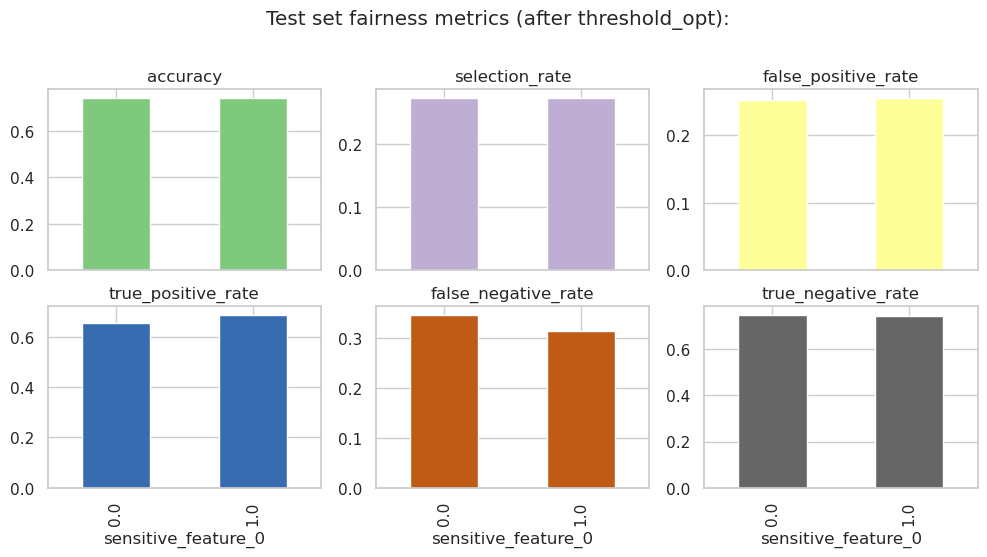

In [96]:
mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Test set fairness metrics (after threshold_opt):",
)


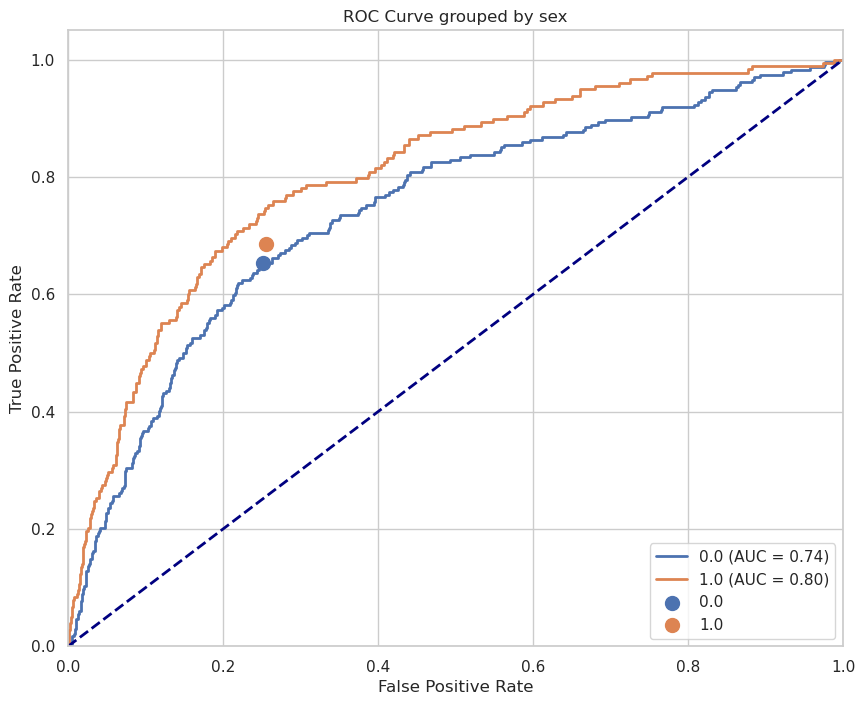

In [97]:
plot_roc_simple(test_lab, test_prob, test_a, y_pre_fair_test,
        sensitive_attribute_name = 'sex',
        )

### To find out how the prediction come from (the new threshold $T_a$)

In [98]:
import json
threshold_rules_by_group = threshold_opt.interpolated_thresholder_.interpolation_dict
print(json.dumps(threshold_rules_by_group, default=str, indent=4))

{
    "0.0": {
        "p_ignore": 0.0,
        "prediction_constant": 0.252,
        "p0": 0.011052631578948044,
        "operation0": "[>0.49337373673915863]",
        "p1": 0.9889473684210519,
        "operation1": "[>0.4376082271337509]"
    },
    "1.0": {
        "p_ignore": 0.18650845463002272,
        "prediction_constant": 0.252,
        "p0": 0.1610538922155691,
        "operation0": "[>0.25991813838481903]",
        "p1": 0.8389461077844309,
        "operation1": "[>0.20158463716506958]"
    }
}


### 💥 Exercise and Discussion:
* Can you write down the new threshold function? ([Hint](https://fairlearn.org/v0.10/user_guide/mitigation/postprocessing.html#postprocessing))
* Compare the results. What do you observe, and does this model seem fair to you?
* Hint: After optimization, you may notice that accuracy (or other metrics) is more balanced between groups. However, the overall accuracy (or other metrics of interest) may decrease for both groups. Do you think this is still a good or acceptable solution?

> Exactly, when we apply new threshold, we find that the Accuracy, TPR and FPR values ​​of group1 and group2 are almost the same. But before using threshold_optimizer, we have a much higher accuracy for group1.


![](./support4notebook/dilemma.jpg)

# PART 2: Potential pitfall: Algorithmic fairness in the presence of label noise
As mentioned in class, it is easy to diagnose algorithmic bias. This is, however, only true if we have access to correct target labels for the test set. In this part of the project, we will simulate a situation where our test set ground truth target labels are incorrect in a biased way: You will simulate overdiagnosis among male individuals, by manually distorting some of their labels. Next, you will analyze how this affects the diagnosis and mitigation of algorithmic bias.

## Write a script to distort the labels for the male individuals according to the following recipe:
* Please create a new set of distorted target labels
* Initialize these as identical to the supplied target labels
* Manually distort them by flipping 30% of the healthy labels for male individuals to diseased. These should be selected at random.





In [99]:
import numpy as np
# create a new set of distorted target labels
distorted_labels_test = y_test.clone()

# Get indices of male individuals (a_test == 1) with healthy labels (distorted_labels_test == 0)
male_indices_test = (a_test == 1) & (distorted_labels_test == 0)
print(f'a_test == 1.shape={np.where(a_test == 1)[0].shape}')
print(f'a_test.shape={a_test.shape}')
print(f'distorted_labels_test == 0.shape={np.where(distorted_labels_test==0)[0].shape}')
print(f'y_test.shape={y_test.shape}')
print(f'male_indices_test.shape={male_indices_test.shape}')
male_healthy_indices_test = np.where(male_indices_test)[0]
print(f'male_healthy_indices_test.shape ={male_healthy_indices_test.shape}')

a_test == 1.shape=(4230,)
a_test.shape=torch.Size([8459])
distorted_labels_test == 0.shape=(8047,)
y_test.shape=torch.Size([8459])
male_indices_test.shape=torch.Size([8459])
male_healthy_indices_test.shape =(4052,)


In [100]:
# Determine the number of labels to flip (30% of healthy male labels)
num_to_flip_test = int(0.3 * len(male_healthy_indices_test))

# Randomly select indices to flip
np.random.seed(42)  # For reproducibility
indices_to_flip_test = np.random.choice(male_healthy_indices_test, size=num_to_flip_test, replace=False)

# Flip the selected labels to diseased (label == 1)
distorted_labels_test[indices_to_flip_test] = 1

# Verify the changes
print(f"Original healthy male labels: {len(male_healthy_indices_test)}")
print(f"Number of labels flipped: {num_to_flip_test}")

Original healthy male labels: 4052
Number of labels flipped: 1215


## Now repeat your analysis from Part 1 for your classifier from Part 1 using the distorted labels. 
You don’t need to retrain the classifier – you will only repeat the diagnosis and mitigation parts.

* Diagnose algorithmic bias with respect to your distorted labels. Do your conclusions change?
* Mitigate algorithmic bias with respect to your distorted labels. Following this, repeat your diagnostic pipeline both with respect to your distorted and original labels. What do you see? Did mitigation ensure improved fairness with respect to the distorted labels? What happened with respect to the actual (original) labels? Is the mitigated algorithm actually fair?


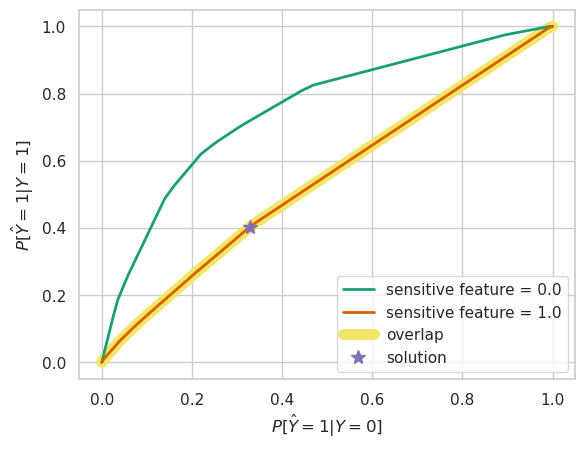

In [101]:
# re-fit ThresholdOptimizer(criterion = equalized_odds)
threshold_opt .fit(X_test_2D, distorted_labels_test, sensitive_features=a_test)
# plot
plot_threshold_optimizer(threshold_opt, ax=None, show_plot=True)

In [102]:
y_distorted_pre_fair_test = threshold_opt.predict(X_test_2D, sensitive_features=a_test)

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.45679166 0.2651374  0.2651374  ... 0.2651374  0.2651374  0.2651374 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

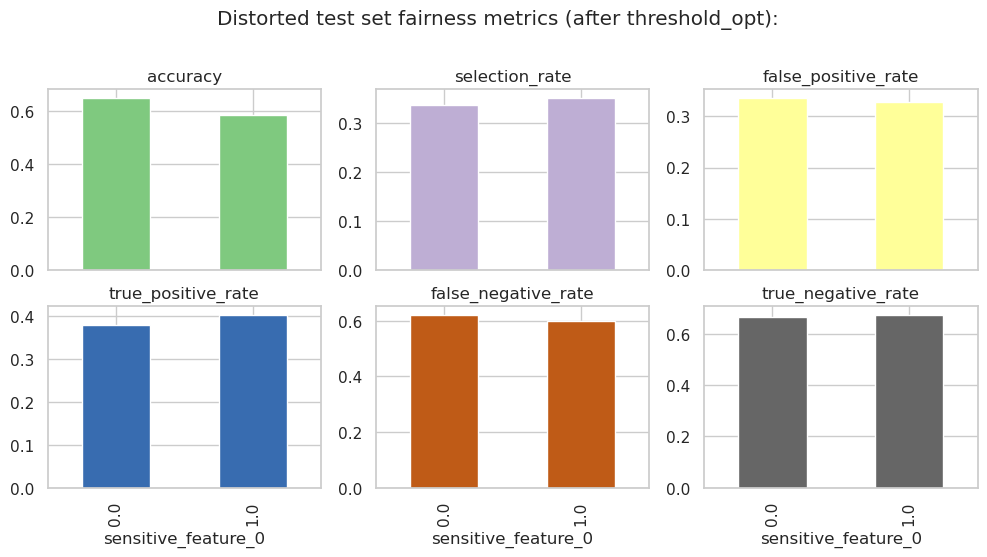

In [103]:
mf = MetricFrame(metrics=metrics,
                 y_true=distorted_labels_test,
                 y_pred=y_distorted_pre_fair_test,
                 sensitive_features=a_test)
mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Distorted test set fairness metrics (after threshold_opt):",
)

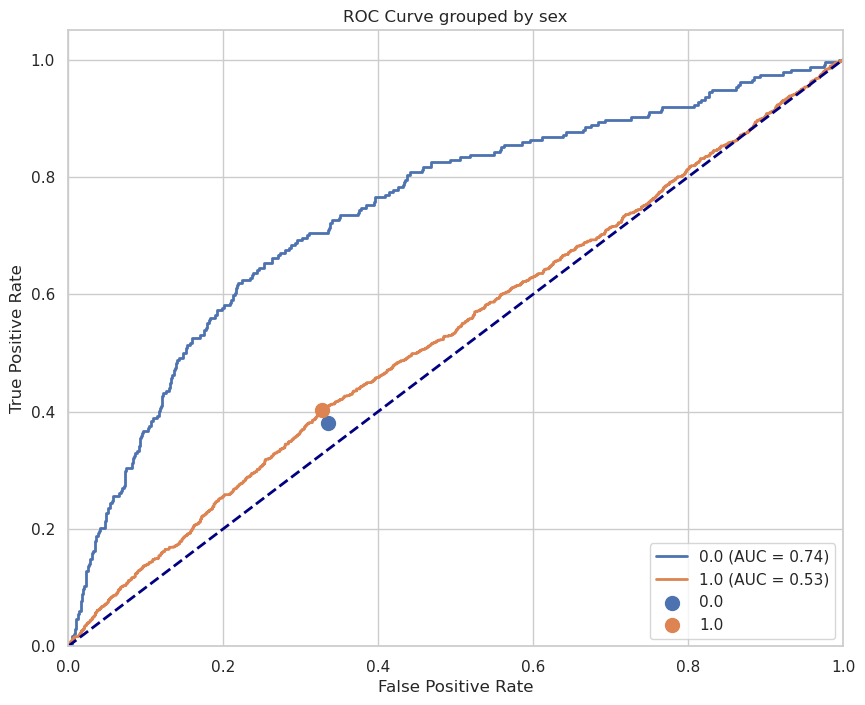

In [104]:
plot_roc_simple(distorted_labels_test, test_prob, test_a, y_distorted_pre_fair_test,
        sensitive_attribute_name = 'sex',
        )

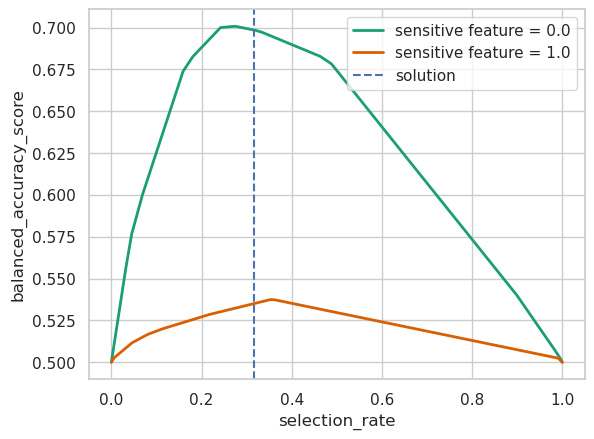

In [105]:
to_demograph = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='demographic_parity', # Independence
    objective='balanced_accuracy_score',  
    predict_method='predict_proba',
)

# fit ThresholdOptimizer
to_demograph.fit(X_test_2D, distorted_labels_test, sensitive_features=a_test)

# plot_threshold_optimizer
plot_threshold_optimizer(to_demograph, ax=None, show_plot=True)

/zhome/21/8/202236/miniconda3/envs/rai_fairness/lib/python3.9/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1. 0. 0. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


array([[<Axes: title={'center': 'accuracy'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: title={'center': 'true_positive_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='sensitive_feature_0'>,
        <Axes: title={'center': 'true_negative_rate'}, xlabel='sensitive_feature_0'>],
       [<Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>,
        <Axes: xlabel='sensitive_feature_0'>]], dtype=object)

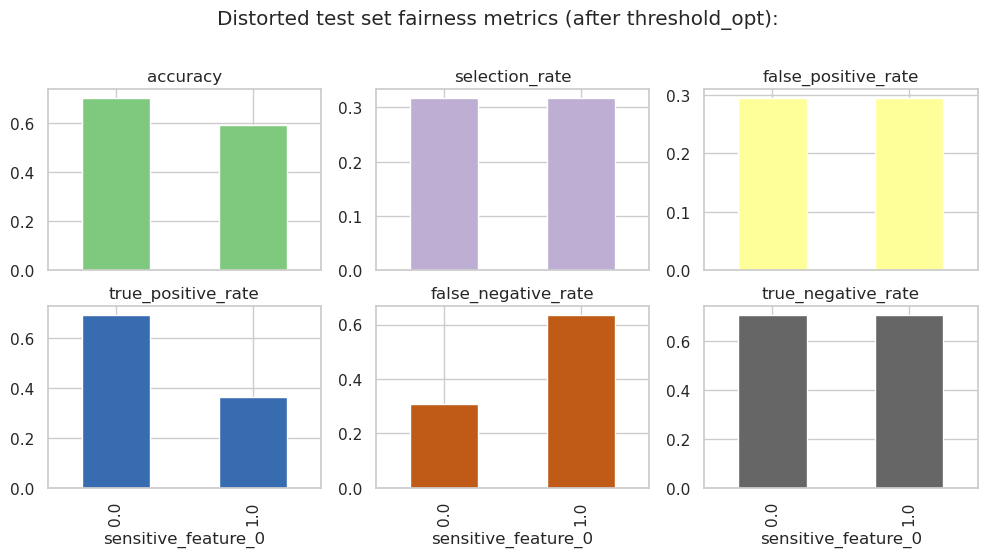

In [106]:
y_distorted_pre_fair_test = to_demograph.predict(X_test_2D, sensitive_features=a_test)
mf = MetricFrame(metrics=metrics,
                 y_true=distorted_labels_test,
                 y_pred=y_distorted_pre_fair_test,
                 sensitive_features=a_test)
mf.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Distorted test set fairness metrics (after threshold_opt):",
)

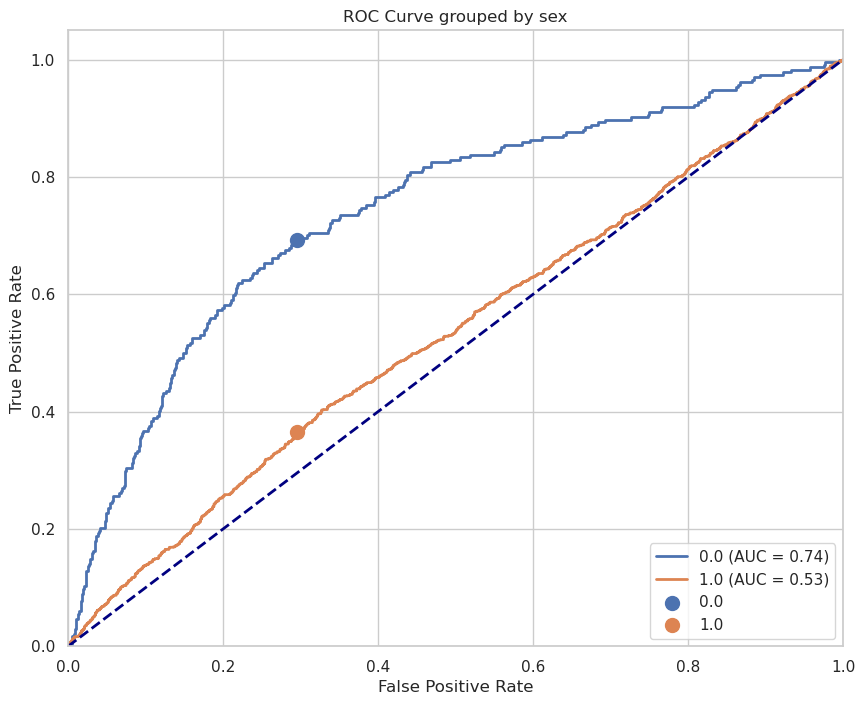

In [107]:
plot_roc_simple(distorted_labels_test, test_prob, test_a, y_distorted_pre_fair_test,
        sensitive_attribute_name = 'sex',
        )

![](./support4notebook/dataset.jpg)